In [68]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import time
import progressbar
import importlib
import random
# torch.manual_seed(1)    # reproducible
plt.style.use('default')
%matplotlib inline

import pdb


import Models_M as mds
import auxillary_functions as aux

# Hyper Parameters
EPOCH = 100
BATCH_SIZE = 256
DOWNLOAD_MNIST = False
m1 = 64
m2 = 128
m3 = 512
cudaopt = True
EPS = 1e-6
histogram_level = int(0.8*np.ceil(100))

# Mnist digits dataset
train_data = torchvision.datasets.MNIST(
    root='../data',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=True,                        # download it if you don't have it
)

# LIMITING TRAINING DATA
Ntrain = int(2e3)

train_set = np.random.permutation(60000)[0:Ntrain]
train_data.train_data = train_data.train_data[torch.LongTensor(train_set),:,:]
train_data.train_labels = train_data.train_labels[torch.LongTensor(train_set)]

test_data = torchvision.datasets.MNIST(
    root='../data',
    train=False,                                     # this is testing data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=True,                        # download it if you don't have it
)

# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = Data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

### Train baseline neural network model

In [69]:
importlib.reload(mds)
importlib.reload(aux)

Loss_test_0 = np.zeros((EPOCH,))
Acc_test_0 = np.zeros((EPOCH,))
Acc_train_0 = np.zeros((EPOCH,))

print('\n\t\t\t\t\tTraining Joint NN \n')

activations_count3_0 = np.zeros((10, m3))

model_0 = mds.ML_NN(m1,m2,m3)
if cudaopt:
    model_0.cuda()

optimizer = torch.optim.Adam(model_0.parameters(), lr = 0.0001, eps = EPS)
bar = progressbar.ProgressBar()

for epoch in range(EPOCH):
#     print("Epoch: " + str(int(epoch)))
    bar.update((epoch+1)/EPOCH*100)
    # train 1 epoch
    model_0.train()
    
    train_correct = 0
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x)   # batch x, shape (batch, 28*28)
        b_y = Variable(y)               # batch label
        if cudaopt:
            b_y, b_x = b_y.cuda(), b_x.cuda()
        encoded, scores,_,_,_ = model_0(b_x)
        
        train_pred = scores.data.max(1, keepdim=True)[1]
        train_correct += train_pred.eq(b_y.data.view_as(train_pred)).long().cpu().sum()
        
        loss = F.nll_loss(scores, b_y)      # negative log likelyhood
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients
    
    Acc_train_0[epoch] =  100 * float(train_correct) /float(len(train_loader.dataset))    
        
    # testing
    model_jnn.eval()
    correct = 0
    test_loss = 0
    for step, (x, y) in enumerate(test_loader):
        b_x = Variable(x)   # batch x, shape (batch, 28*28)
        b_y = Variable(y)               # batch label
        if cudaopt:
            b_y, b_x = b_y.cuda(), b_x.cuda()
        gamma, scores,_,_,gamma3 = model_0(b_x)
        if epoch >= histogram_level:
            activations_count3_0 += aux.compute_histogram(gamma3, m3, b_y)
        
        test_loss += F.nll_loss(scores, b_y, size_average=False).data[0]
        pred = scores.data.max(1, keepdim=True)[1]
        correct += pred.eq(b_y.data.view_as(pred)).long().cpu().sum()
        
    test_loss /= len(test_loader.dataset)
    Loss_test_0[epoch] = test_loss
    Acc_test_0[epoch] =  100*float(correct)/float(len(test_loader.dataset))
    
# torch.save(model_nn.state_dict(), 'nn_model.pt')

/ |#                                                  | 0 Elapsed Time: 0:00:00


					Training Joint NN 



/anaconda/envs/mlvm/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
| |                                               # | 100 Elapsed Time: 0:02:02

### Train joint neural network model

In [70]:
importlib.reload(mds)
importlib.reload(aux)

Loss_test_jnn = np.zeros((EPOCH,))
Acc_test_jnn = np.zeros((EPOCH,))
Acc_train_jnn = np.zeros((EPOCH,))

print('\n\t\t\t\t\tTraining Joint NN \n')

activations_count3_jnn = np.zeros((10, m3))

model_jnn = mds.ML_JNN_ReLU(m1,m2,m3)
if cudaopt:
    model_jnn.cuda()

optimizer = torch.optim.Adam(model_jnn.parameters(), lr = 0.0001, eps = EPS)
bar = progressbar.ProgressBar()

for epoch in range(EPOCH):
#     print("Epoch: " + str(int(epoch)))
    bar.update((epoch+1)/EPOCH*100)
    # train 1 epoch
    model_jnn.train()
    
    train_correct = 0
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x)   # batch x, shape (batch, 28*28)
        b_y = Variable(y)               # batch label
        if cudaopt:
            b_y, b_x = b_y.cuda(), b_x.cuda()
        encoded, scores = model_jnn.forward_joint(b_x, b_y)
        
        train_pred = scores.data.max(1, keepdim=True)[1]
        train_correct += train_pred.eq(b_y.data.view_as(train_pred)).long().cpu().sum()
        
        loss = F.nll_loss(scores, b_y)      # negative log likelyhood
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients
    
    Acc_train_jnn[epoch] =  100 * float(train_correct) /float(len(train_loader.dataset))    
        
    # testing
    model_jnn.eval()
    correct = 0
    test_loss = 0
    for step, (x, y) in enumerate(test_loader):
        b_x = Variable(x)   # batch x, shape (batch, 28*28)
        b_y = Variable(y)               # batch label
        if cudaopt:
            b_y, b_x = b_y.cuda(), b_x.cuda()
        gamma, scores,_,_,_ = model_jnn.forward(b_x)
        
        if epoch >= histogram_level:
            activations_count3_jnn += aux.compute_histogram(gamma3, m3, b_y)
        
        test_loss += F.nll_loss(scores, b_y, size_average=False).data[0]
        pred = scores.data.max(1, keepdim=True)[1]
        correct += pred.eq(b_y.data.view_as(pred)).long().cpu().sum()
        
    test_loss /= len(test_loader.dataset)
    Loss_test_jnn[epoch] = test_loss
    Acc_test_jnn[epoch] =  100*float(correct)/float(len(test_loader.dataset))
    
# torch.save(model_jnn.state_dict(), 'jnn_model.pt')

/ |#                                                  | 0 Elapsed Time: 0:00:00


					Training Joint NN 



/anaconda/envs/mlvm/lib/python3.6/site-packages/ipykernel/__main__.py:57: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
| |        #                                        | 100 Elapsed Time: 0:02:06

### Plot test and train accuracies

/anaconda/envs/mlvm/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


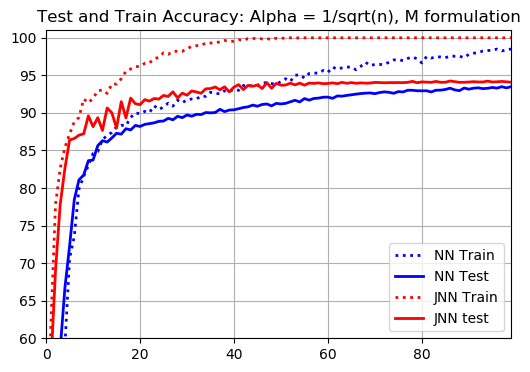

In [71]:
plt.style.use('default')
fig = plt.figure(figsize=(6,4))
plt.plot(Acc_train_0, ':b', linewidth = 2,label='NN Train')
plt.plot(Acc_test_0,'b',linewidth = 2,label='NN Test')
plt.plot(Acc_train_jnn,':r', linewidth = 2,label = 'JNN Train')
plt.plot(Acc_test_jnn,'r', linewidth = 2,label = 'JNN test')
plt.grid('on')
plt.title('Test and Train Accuracy: Alpha = n, M formulation')
plt.legend()
plt.axis([0, EPOCH-1, 60, 101])
plt.show()

## Visualise global filters of baseline

torch.Size([512, 64, 12, 12])
Filters - NN


<Figure size 640x480 with 0 Axes>

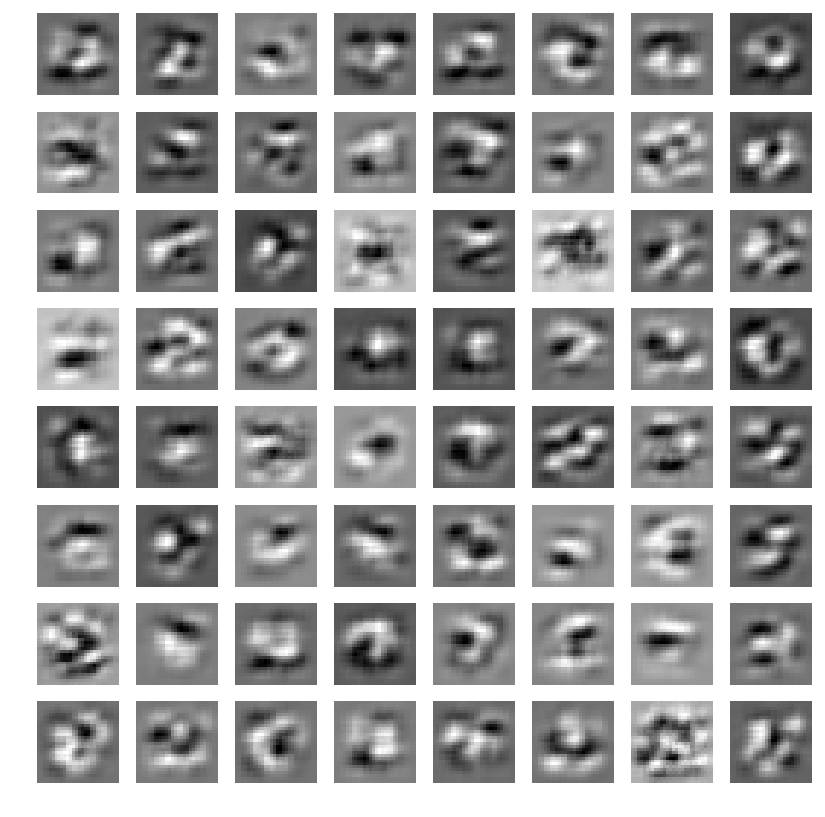

Filters - JNN


<Figure size 640x480 with 0 Axes>

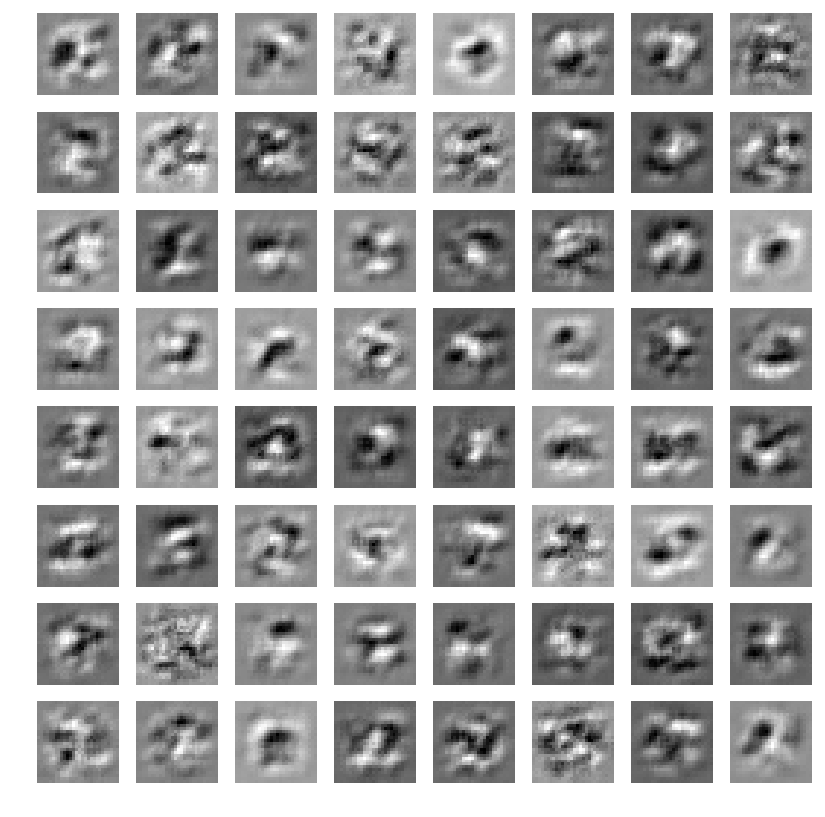

In [72]:
cols = 8
rows = 8
indices = random.sample(range(m3), cols*rows)

dict1 = model_0.W3
atom1_dim = dict1.shape[3]
# print(dict1.shape)

dict2 = F.conv_transpose2d(dict1, model_0.W2, stride=model_0.strd1, dilation=1)
atom2_dim = dict2.shape[3]
print(dict2.shape)

dict3_0 = F.conv_transpose2d(dict2, model_0.W1, stride=model_0.strd2, dilation=1)
atom3_dim = dict3_0.shape[3]
# print(dict3_0.shape)

dict1 = model_jnn.W3
atom1_dim = dict1.shape[3]
# print(dict1.shape)

dict2 = F.conv_transpose2d(dict1, model_jnn.W2, stride=model_jnn.strd1, dilation=1)
atom2_dim = dict2.shape[3]
# print(dict2.shape)

dict3_jnn = F.conv_transpose2d(dict2, model_jnn.W1, stride=model_jnn.strd2, dilation=1)
atom3_dim = dict3_jnn.shape[3]
# print(dict3_jnn.shape)

print('Filters - NN')

idx = 1
plt.figure(1)
plt.figure(figsize=(10,10))
for j in range(rows):
    for i in range(cols):
        plt.subplot(cols,rows,idx)
        plt.imshow(np.reshape(dict3_0.cpu().data.numpy()[idx-1], (atom3_dim, atom3_dim)), cmap='gray')
        plt.axis('off')
        idx+=1
plt.show()
        
print('Filters - JNN')

idx = 1
plt.figure(2)
plt.figure(figsize=(10,10))
for j in range(rows):
    for i in range(cols):
        plt.subplot(cols,rows,idx)
        plt.imshow(np.reshape(dict3_jnn.cpu().data.numpy()[idx-1], (atom3_dim, atom3_dim)), cmap='gray')
        plt.axis('off')
        idx+=1

plt.show()

### Plot histogram activations

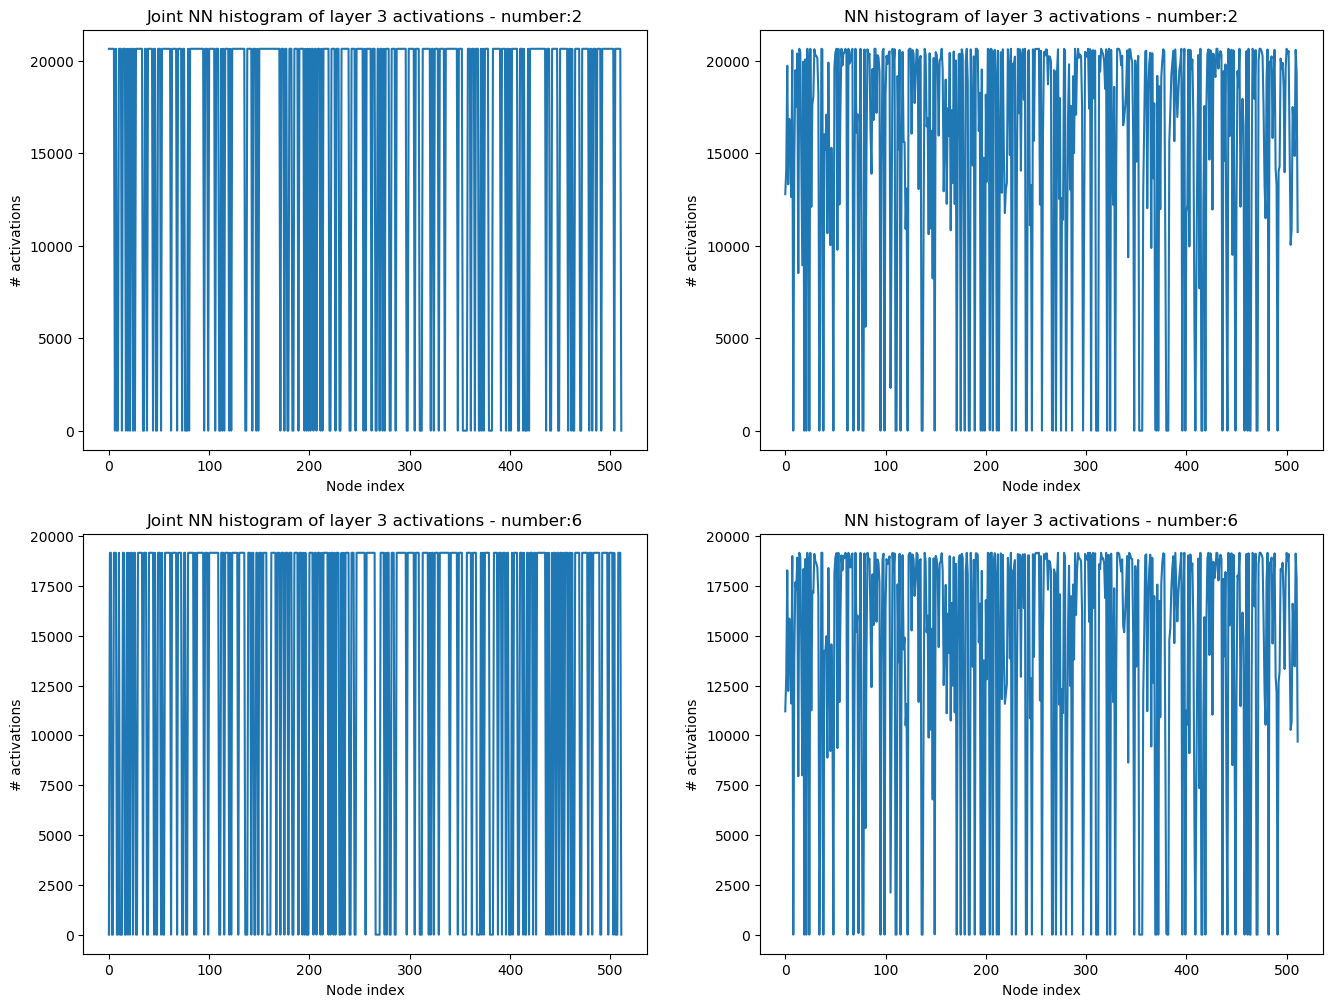

In [78]:
idx1 = 2
idx2 = 6

plt.figure(figsize=(16,12))
plt.subplot(2,2,1)
plt.plot(np.arange(m3), activations_count3_jnn[idx1,:])
plt.title('Joint NN histogram of layer 3 activations - number:' + str(idx1))
plt.xlabel('Node index')
plt.ylabel('# activations')
plt.subplot(2,2,2)
plt.plot(np.arange(m3), activations_count3_0[idx1,:])
plt.title('NN histogram of layer 3 activations - number:' + str(idx1))
plt.xlabel('Node index')
plt.ylabel('# activations')
plt.subplot(2,2,3)
plt.plot(np.arange(m3), activations_count3_jnn[idx2,:])
plt.title('Joint NN histogram of layer 3 activations - number:' + str(idx2))
plt.xlabel('Node index')
plt.ylabel('# activations')
plt.subplot(2,2,4)
plt.plot(np.arange(m3), activations_count3_0[idx2,:])
plt.title('NN histogram of layer 3 activations - number:' + str(idx2))
plt.xlabel('Node index')
plt.ylabel('# activations')
plt.show()